# NEUROTOOL: SPINDLE AND SLOW WAVE MODULATION ANALYSIS
This notebook is a pipeline to use Neurotool for analyzing the modulation between sleep spindles and spike trains in single channel data. 

__NOTE: Be careful with the memory while using this tool, it might be a good idea to allocate some parts of SSD to be used like RAM so that you don't get a MemoryError.__

__NOTE: In order to get the same results with the example in this notebook, you should download [this](https://drive.google.com/open?id=1lprAYR28n5QY53Yz-Ija4TaS4OytuWGy) data and put the following files into this folder:__

- BWRat17_121712_SStable.mat
- BWRat17_121712.eeg 

## 1. Import the packages required for running the script

Please run the block of code to import the Python packages that are required for running the rest of this script. Make sure that the following files are in the same directory with this notebook:

- analysis_utils
- spindle_analysis_utils

In [1]:
import numpy as np
import matplotlib.pyplot as plt
#import ipywidgets
#from ipywidgets import Layout, HBox, VBox
#from IPython.display import display
#import h5py
import scipy
import scipy.io as spio
from analysis_utils import *
from spindle_analysis_utils import *
#from extract_data import *

## 2. Entering parameters for data

Please enter the values for the data and spike train that you want to analyze. __This is not a complete tool yet!!!__

In [ ]:
##Name of the data file 

name_html = ipywidgets.HTML(value = "<p><b>Name of the single channel data:</b><br />Enter the name of the raw data file that is in data folder in this directory.</p>")
name = ipywidgets.Text(value = "", placeholder = "Enter name of the file", disabled = False)
display(VBox([name_html, name]))

##File format
ff_html = ipywidgets.HTML(value = "<p><b>File format of data:</b><br />(dat for .dat, cont for .continuous, rhd for .rhd)</p>")
ff = ipywidgets.Text(value = 'dat', placeholder = 'Enter file format for data',
             disabled = False)
display(VBox([ff_html,ff]))

#Units of the data

unit_html = ipywidgets.HTML(value = "<b>Units of the data:</b>")
unit = ipywidgets.Dropdown(options=['Volts', 'MiliVolts', 'MicroVolts'], 
                   value = 'Volts',  disabled = False)
display(VBox([unit_html, unit]))

##file name of the spike train

st_html = ipywidgets.HTML(value = "<p><b>Name of the spike train data file:</b><br />Enter the name of the spike train data file that is in data folder in this directory.</p>")
st = ipywidgets.Text(value = "", placeholder = "Enter name of the file", disabled = False)
display(VBox([st_html, st]))

##File format
ffst_html = ipywidgets.HTML(value = "<p><b>File format of spike train:</b><br />(dat for .dat, cont for .continuous, rhd for .rhd)</p>")
ffst = ipywidgets.Text(value = 'dat', placeholder = 'Enter file format for data',
             disabled = False)
display(VBox([ffst_html,ffst]))

##Sampling frequency of the data

fs_html = ipywidgets.HTML(value = "<p><b>Sampling frequency of the data:</b><br />Enter the sampling frequency of the recording.</p>")
fs = ipywidgets.Text(value = "", placeholder = "Enter sampling frequency", disabled = False)
display(VBox([fs_html, fs]))

## 3. Obtaining the dataset

Please run the following script obtain the parameters in the dataset.

In [2]:
# script to obtain single channel data, its spike train, and sampling frequency
#data = get_data(name.value, ff.value, unit.value)
#spike_train = get_spike_train_data(st.value, ffst.value)
noc = 72
fs = 1250
sf = 30000
raw_data = np.fromfile('BWRat17_121712.eeg', 'int16')
num_samples = int(len(raw_data)/ noc)
data = np.transpose(np.reshape(raw_data, [num_samples, noc]))[12][0:5000000]
l = len(data)
times0 = np.arange(l)
times0 = times0 / fs
del raw_data
data0 = data
data = signal.resample(data,int(sf*l*(1/fs)))
l = len(data)
l0 = len(data0)
times = np.arange(l)
times = times / sf

In [3]:
stable_spike_matlab = spio.loadmat("BWRat17_121712_SStable.mat")
num_of_units = len(stable_spike_matlab["S_CellFormat"][0])
peak_index = []
spike_train = []

for unit_index in range(num_of_units):
    data_add = []
    for j in stable_spike_matlab["S_CellFormat"][0][unit_index]:
        if j * sf < l:
            data_add.append(int(j * sf))
    peak_index.append(data_add)
    spike_train.append(get_spike_train(peak_index[unit_index], l))
del data_add

In the code above, we obtained the LFP data and spike trains from our files. When you want to work with your own data you should extract your data from your files as a numpy array. Here because we had spike trains found in a different sampling frequency, we upsampled the data for further use, however this will not be neccessary when you want to work on your own data. Every element in the spike train data is the spike train of each unit as an array of same length with data. 

## 4. Plotting the data and spike train in a specific time range

Default time range is all data, but it is recommended to be changed. For example, spike train of the third unit is plotted.

<IPython.core.display.Javascript object>


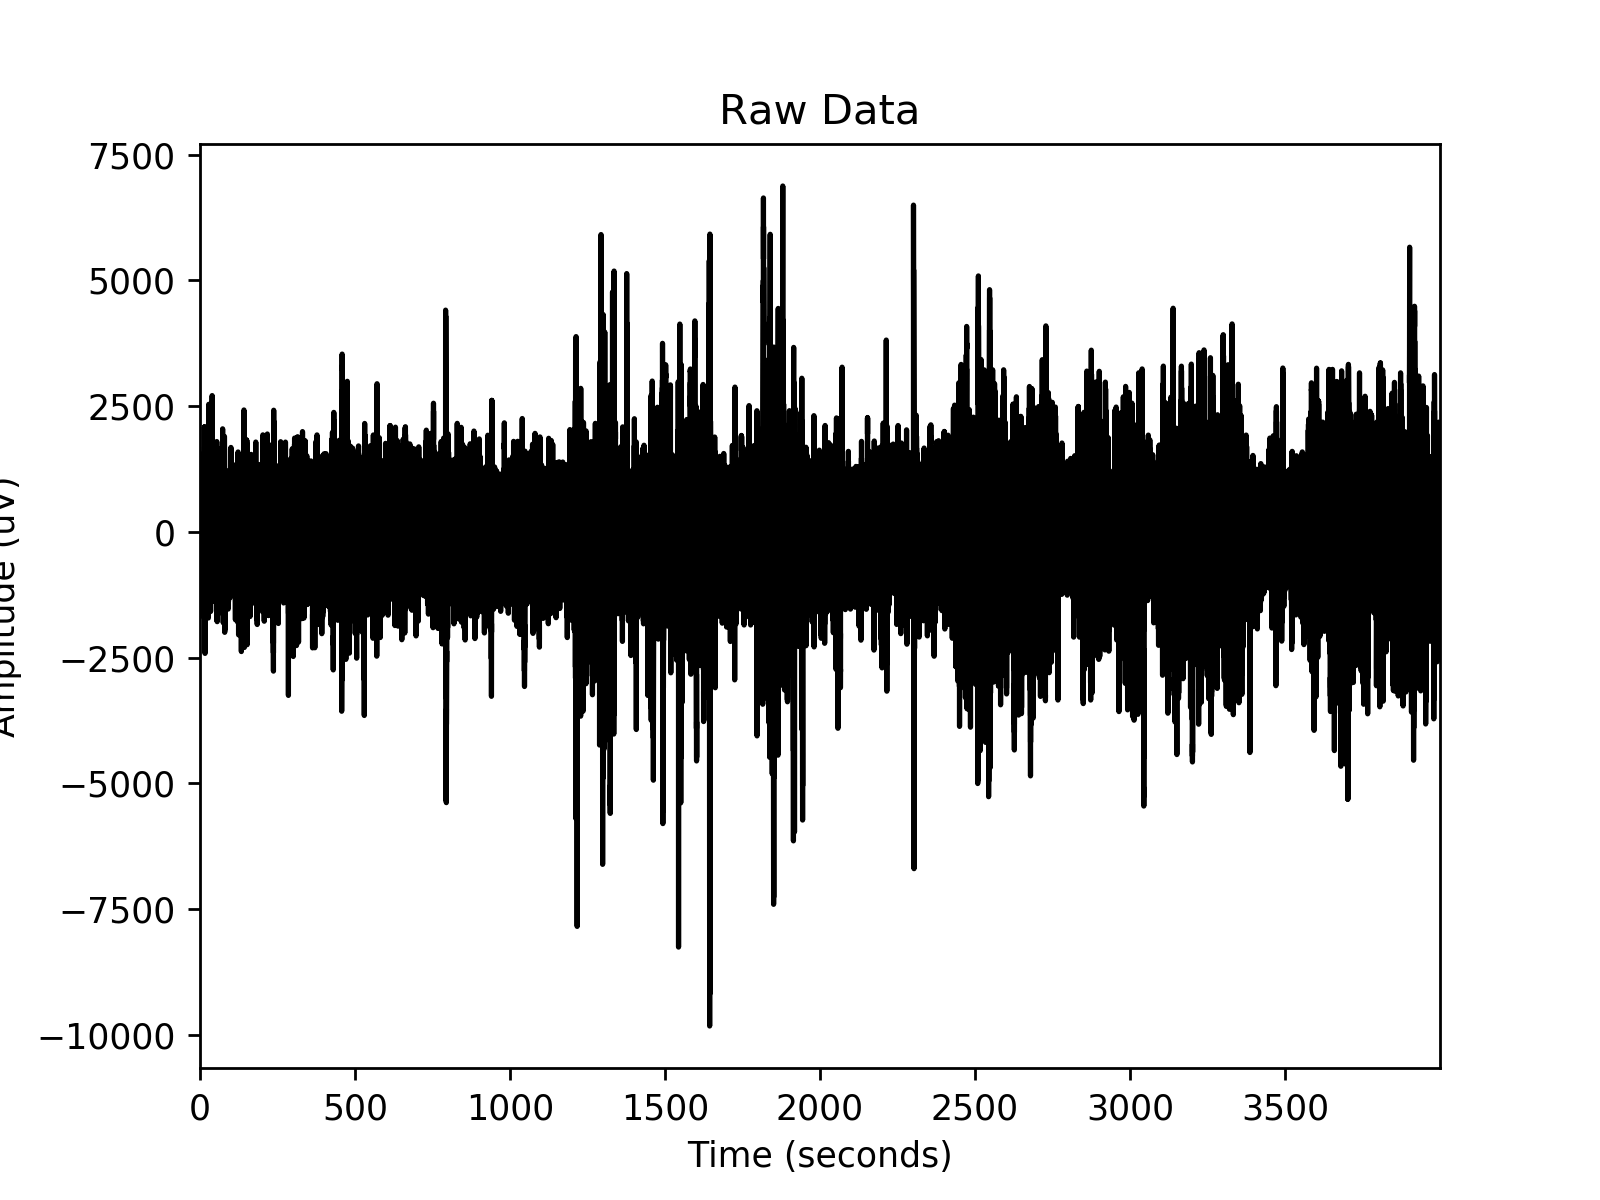

In [4]:
%matplotlib notebook
plot_data(data0, times0, 'Time (seconds)', 'Amplitude (uV)','Raw Data', [times0.min(), times0.max()])

<IPython.core.display.Javascript object>


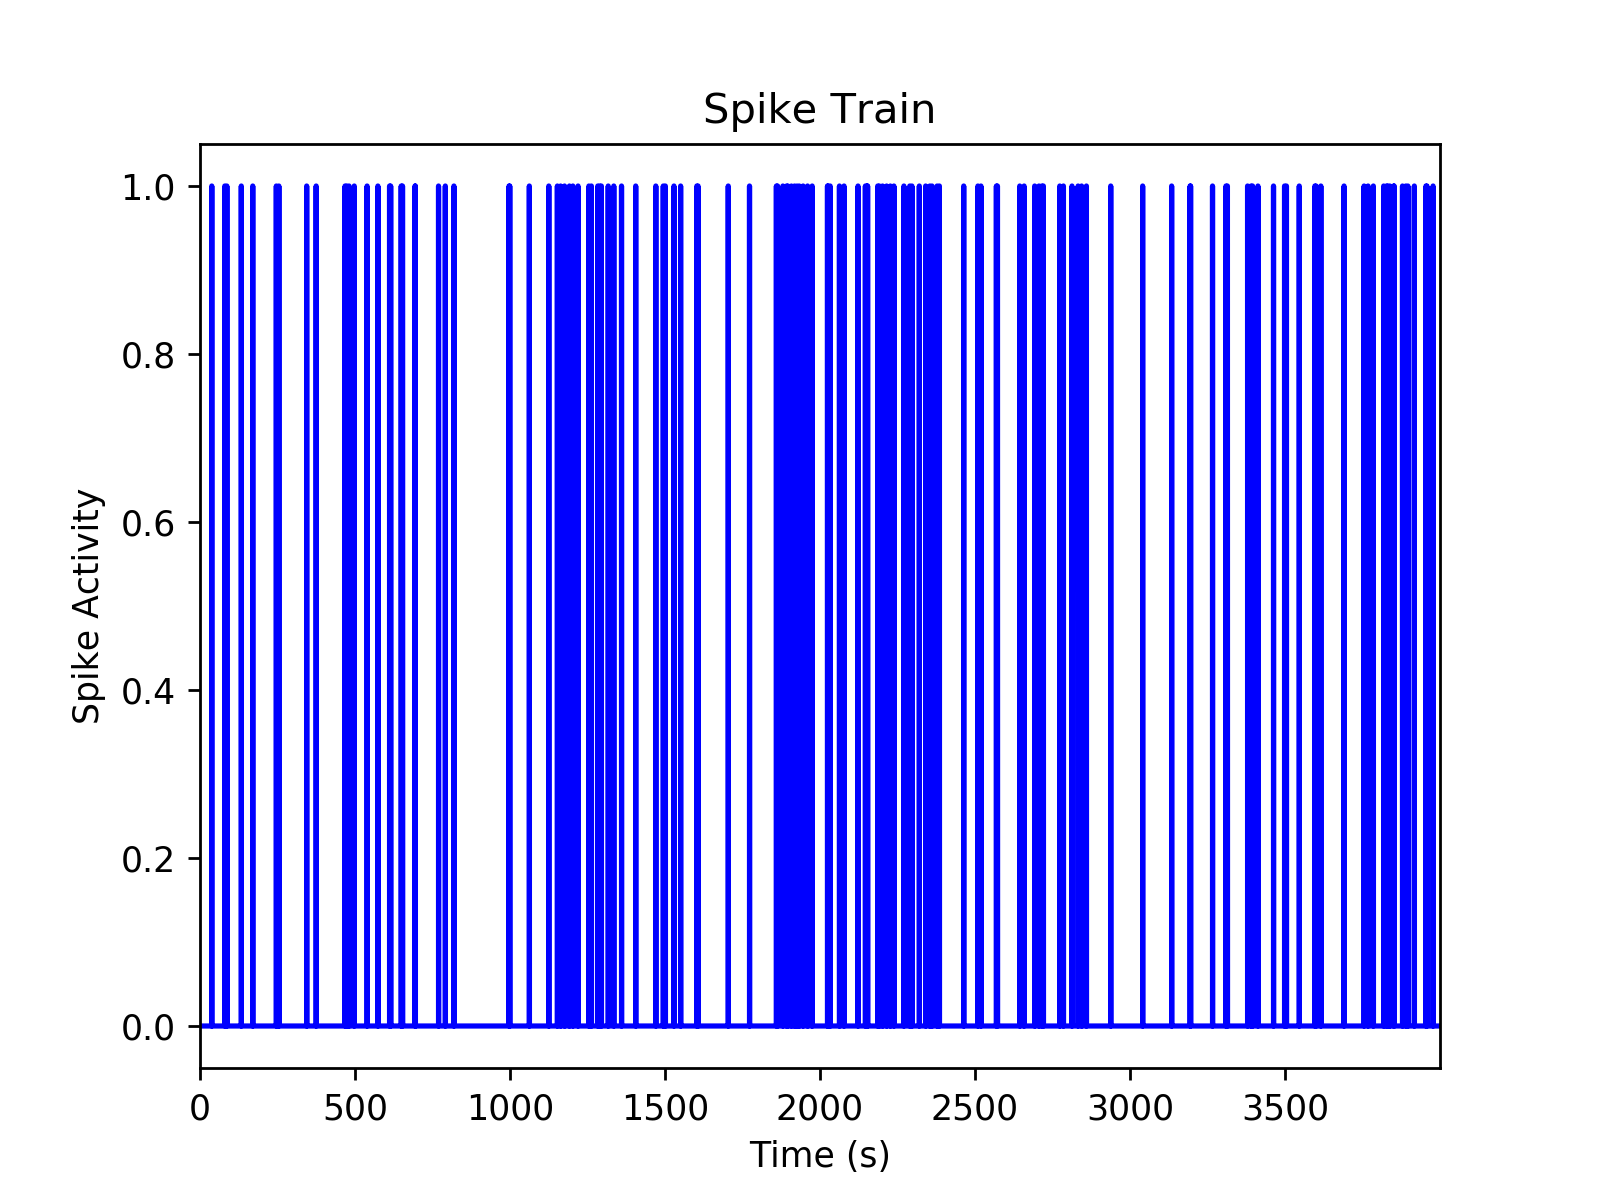

In [5]:
%matplotlib notebook
plot_spike_train(spike_train[2], times, [times.min(), times.max()])

## 5. Finding spindles inside the data

Here you can change the threshold values for the detection algorithm if you want to. More on algorithm can be found [here](https://github.com/raphaelvallat/yasa).

In [6]:
#THIS MIGHT TAKE TIME DEPENDING ON SIZE OF THE DATA AND YOUR COMPUTER
sp = find_spindles(data0, fs, thresh={'rel_pow': 0.2, 'corr': 0.48, 'rms': 1.5})
sp.round(2) 

21-Aug-19 16:23:19 | WARNING | Cannot downsample if sf is not a mutiple of 100 or 128. Skipping downsampling.


,Start,End,Duration,Amplitude,RMS,AbsPower,RelPower,Frequency,Oscillations,Symmetry
0,2506.92,2507.48,0.56,1748.74,406.83,5.17,0.24,13.50,7.0,0.31
1,2557.43,2558.03,0.60,1909.03,429.76,5.03,0.25,13.41,7.0,0.40
2,2678.23,2678.89,0.66,1605.62,339.30,4.87,0.31,12.98,8.0,0.20
3,2688.18,2688.83,0.64,2491.26,529.68,5.47,0.30,13.64,8.0,0.18
4,2708.55,2709.14,0.59,1829.21,486.62,5.18,0.23,12.58,7.0,0.50
5,2913.52,2914.02,0.50,2229.22,515.75,5.28,0.23,12.62,6.0,0.19
6,3024.97,3026.15,1.18,1864.41,433.20,4.95,0.27,13.23,13.0,0.39
7,3132.66,3133.29,0.62,1527.20,344.37,4.95,0.23,12.98,7.0,0.24
8,3171.58,3172.13,0.56,1714.44,353.69,4.95,0.24,13.22,7.0,0.54
9,3192.86,3194.01,1.16,2107.06,449.30,4.99,0.22,12.44,12.0,0.72


## 6. Plotting spindles on top of the data in a specific time range

Default time range is all data, but it is recommended to be changed.

<IPython.core.display.Javascript object>


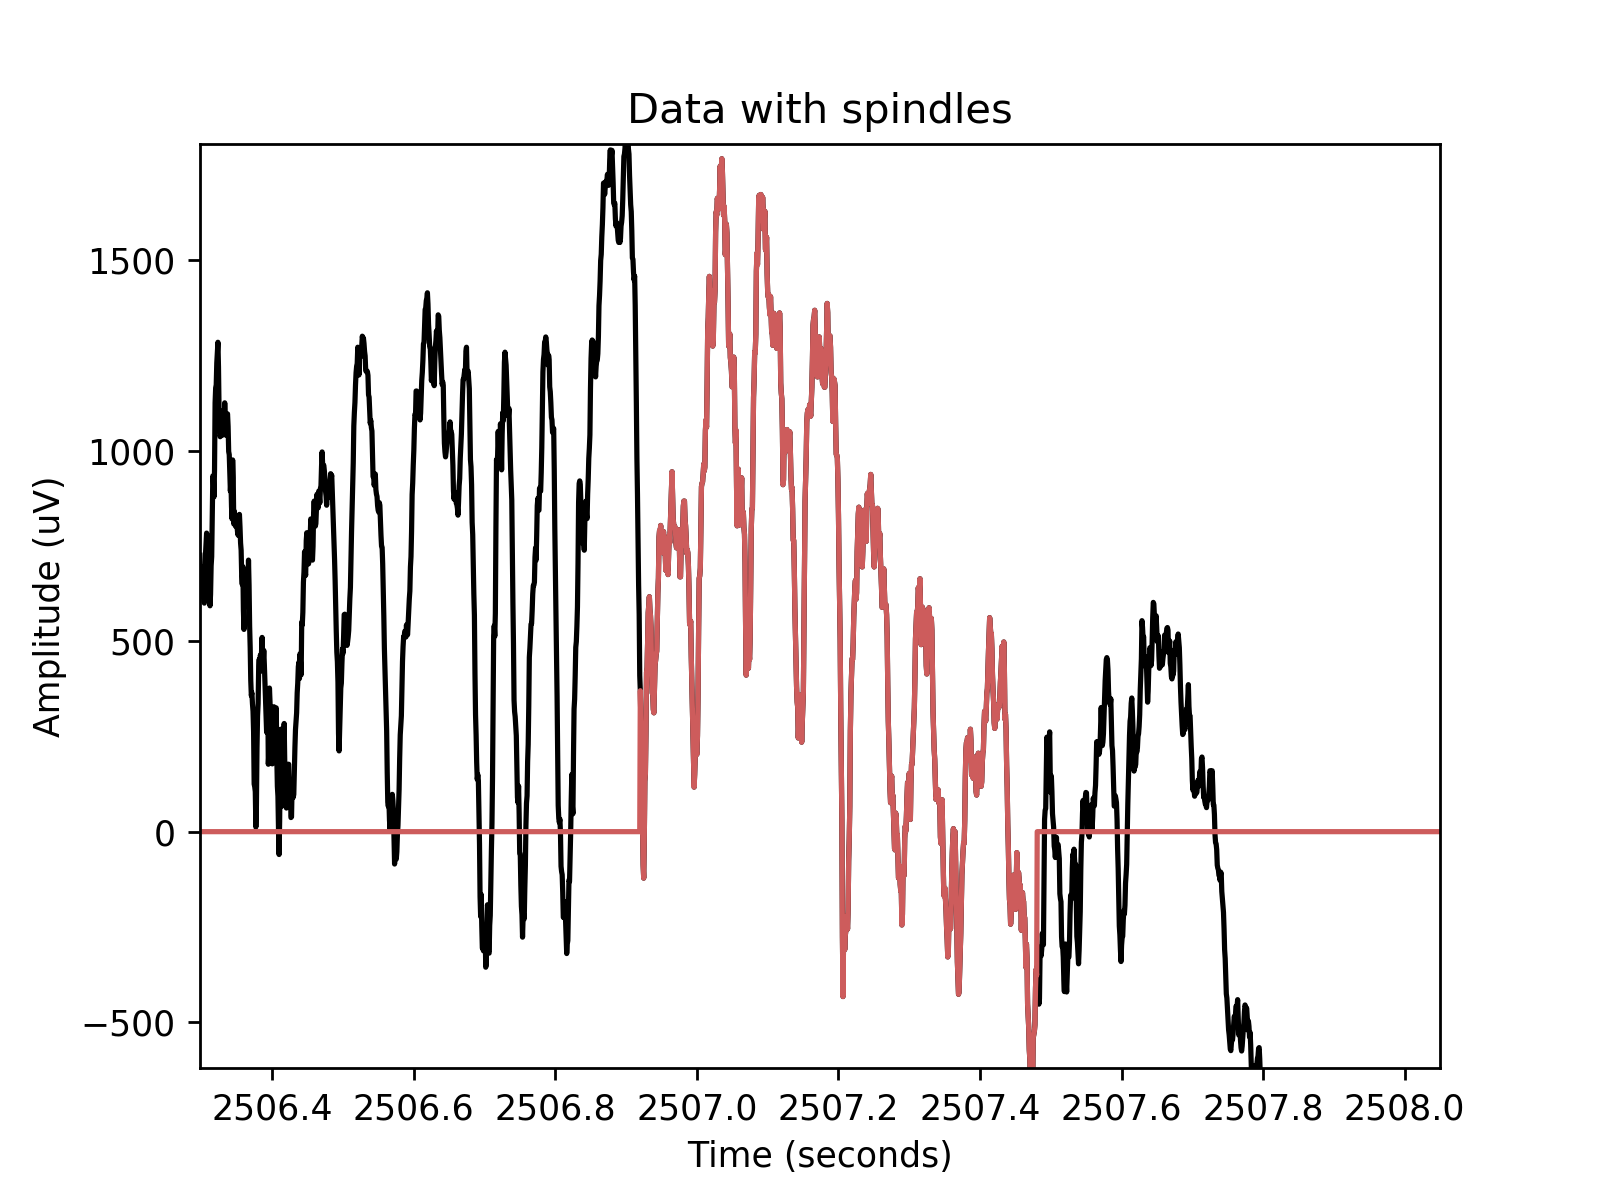

In [24]:
%matplotlib notebook
plot_spindles(data0, times0, fs, sp, 'Time (seconds)', 'Amplitude (uV)', 'Data with spindles', [times0.min(), times0.max()])

## 7. Saving each spindle raw data

Here we will save the raw data for each spindle, in the following format: {'0': [spindle0rawdata], '1': [spindle1rawdata], ....}

In [8]:
spindle_dict = save_spindles(data0, fs, sp)

## 8. Calculating and saving firing histogram of each unit before, during and after spindle
This function will output the following:

For each unit:

[Average firing rate of the unit in the following time interval [start - dt:start], Average firing rate of the unit in the following time interval [spindle duration], Average firing rate of the unit in the following time interval [end : end + dt]]

You can access this information by indexing the output array[unit_index]

In [9]:
#THIS MIGHT TAKE TIME DEPENDING ON SIZE OF THE DATA AND YOUR COMPUTER
dt = 2
unit_spindle_firing = firing_rate_spindle(sp, spike_train, sf, dt)

## 9. Calculating the spindle phase histograms and time/phase aligned spindle spike trains and saving all the data
This function takes the spike train of all units, its samplng frequency, spindle dataFrame, and phase intervals as the input
in order to output the following:
[num_spikes, phase_hist_spike_trains, time_spike_trains, unit_hist_arrays]

1. num_spikes is an array showing how many spikes in total are found in spindles, for each unit. You can access the data by indexing the array with unit_index
2. phase_hist_spike_trains is a dictionary which holds the phase histograms of each spindle, for each unit. To access the data, first you should index the
unit_index in dictionary, (e.g. arr[str(unit_index)]) then the spindle number.
3. time_spike_trains is a dictionary which holds time aligned spike trains in spindles, for each unit. Data can be accessed as demonstrated in 
phase_hist_spike_trains explanation
4. unit_hist_arrays is a dictionary holding sums of the phase histogram arrays for all spindles, for each unit. 
You can access the data by indexing the array with unit_index

Here you can change the phase intervals of the histogram by changing the variable, 'phase'. 

In [10]:
#THIS MIGHT TAKE TIME DEPENDING ON SIZE OF THE DATA AND YOUR COMPUTER
phase = np.pi/6
spindle_allunits = spindle_all_units(sp, phase, sf, spike_train)

num_spikes = spindle_allunits[0]
phase_hist_spike_trains = spindle_allunits[1]
time_spike_trains = spindle_allunits[2]
unit_hist_arrays = spindle_allunits[3]

del spindle_allunits

## 10. Calculating spindle envelope phase histogram and phase aligned spindle envelope spike trains

Here you can change the phase intervals of the histogram by changing the variable, 'phase'. 

This function's output type is the same with spindle_all_units, except the fact that it only returns phase histograms and their sum because others are already calculated.

In [11]:
phase = np.pi/6
spindle_envelope_allunits = spindle_envelope_all_units(sp, phase, sf, spike_train)

phase_hist_envelope_spike_trains = spindle_envelope_allunits[0]
unit_hist_envelope_arrays = spindle_envelope_allunits[1]

del spindle_envelope_allunits

## 11. Calculating spindle and spindle envelope phase histogram and phase aligned spindle envelope of a spike train of a specific unit

Using the following functions, you can directly calculate the phase_hist_spike_train, time_spike_train, and unit_hist_array of a specific unit by indexing its unit index for spike train. See the notebooks file to understand outputs of these functions.

- spindle_envelope_phase_hist(sp, phase, fs, spike_train[unit_index])
- spindle_phase_hist(sp, phase, fs, spike_train[unit_index])

## 12. Saved results

At the end of this analysis, we have the following dictionaries:

- spindle_dict
- num_spikes
- unit_spindle_firing
- phase_hist_spike_trains
- time_spike_trains
- unit_hist_arrays
- phase_hist_envelope_spike_trains
- unit_hist_envelope_arrays

Each storing the following information, respectively:

- Each spindle's raw data in spindle time window
- Number of spikes that are found in spindles for each unit
- Firing rate for each unit before, during, and after spindles
- Phase aligned spike trains of each unit in each spindle
- Time aligned spike trains of each unit in each spindle
- Sum of the all phase aligned spike trains in all spindles for each unit
- Phase aligned spike trains of each unit in each spindle envelope
- Sum of the all phase aligned spike trains in all spindle envelopes for each unit


You can access these variables for any purpose. Run the following cells to print the data inside them.

In [12]:
spindle_dict

{'0': array([ 370,  287,   89,   59,   15,  -87, -122,  -24,  132,  152,  263,
         418,  431,  503,  575,  595,  617,  583,  567,  535,  417,  364,
         361,  321,  312,  373,  437,  449,  465,  474,  544,  627,  666,
         773,  791,  785,  804,  739,  747,  735,  732,  788,  751,  747,
         732,  686,  718,  719,  685,  675,  730,  778,  758,  805,  851,
         893,  945,  889,  823,  806,  801,  801,  793,  755,  745,  785,
         769,  758,  793,  751,  669,  669,  737,  765,  753,  807,  855,
         868,  868,  820,  803,  773,  731,  740,  732,  697,  636,  548,
         542,  553,  460,  390,  314,  240,  192,  117,  150,  197,  201,
         211,  203,  252,  360,  532,  665,  672,  692,  810,  906,  915,
         918,  939,  965,  947,  957, 1054, 1081, 1062, 1174, 1317, 1350,
        1416, 1458, 1414, 1421, 1382, 1332, 1325, 1275, 1297, 1386, 1389,
        1420, 1574, 1628, 1618, 1663, 1655, 1643, 1635, 1683, 1747, 1717,
        1743, 1767, 1734, 1677, 1

In [13]:
num_spikes

array([ 10,   4,   1,   8,  15,   0,   0,   6,   8,  26,  17,  21,  27,
        12,  53,  10,   5,   0,  19,  37,   6,  57,   0,   4,  17,  10,
        14,  24,   9,   5,  12,   4,   0,  11,  14,   8,   1,  11,  15,
       118,   1,   4,   9,   0,   7,   3, 149,  37,  37,  33])

In [14]:
unit_spindle_firing

array([[ 0.3       ,  0.69568117,  0.25      ],
       [ 0.175     ,  0.25680674,  0.275     ],
       [ 0.        ,  0.0432526 ,  0.075     ],
       [ 0.65      ,  0.5869711 ,  0.825     ],
       [ 1.425     ,  1.0574835 ,  1.        ],
       [ 0.        ,  0.        ,  0.025     ],
       [ 0.025     ,  0.        ,  0.        ],
       [ 0.4       ,  0.44188955,  0.525     ],
       [ 0.275     ,  0.44821403,  0.45      ],
       [ 2.2       ,  1.63960289,  1.475     ],
       [ 1.075     ,  1.16150353,  0.525     ],
       [ 1.325     ,  1.2993284 ,  1.575     ],
       [ 0.975     ,  1.83047416,  1.325     ],
       [ 0.625     ,  0.8519154 ,  0.4       ],
       [ 2.25      ,  3.34943436,  2.825     ],
       [ 0.9       ,  0.66303619,  0.825     ],
       [ 0.275     ,  0.37796236,  0.375     ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.9       ,  1.36095748,  1.3       ],
       [ 2.05      ,  2.24523356,  1.8       ],
       [ 0.15      ,  0.40024641,  0.1  

In [15]:
phase_hist_spike_trains

{'0': {'0': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
   [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330]],
  '1': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
   [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330]],
  '2': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
   [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330]],
  '3': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
   [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330]],
  '4': [[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
   [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330]],
  '5': [[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
   [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330]],
  '6': [[1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
   [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330]],
  '7': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
   [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330]],
  '8': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
   [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330]],
  '9': [[0, 0, 0, 0, 0, 0, 0, 0,

In [16]:
time_spike_trains

{'0': {'0': array([0., 0., 0., ..., 0., 0., 0.]),
  '1': array([0., 0., 0., ..., 0., 0., 0.]),
  '2': array([0., 0., 0., ..., 0., 0., 0.]),
  '3': array([0., 0., 0., ..., 0., 0., 0.]),
  '4': array([0., 0., 0., ..., 0., 0., 0.]),
  '5': array([0., 0., 0., ..., 0., 0., 0.]),
  '6': array([0., 0., 0., ..., 0., 0., 0.]),
  '7': array([0., 0., 0., ..., 0., 0., 0.]),
  '8': array([0., 0., 0., ..., 0., 0., 0.]),
  '9': array([0., 0., 0., ..., 0., 0., 0.]),
  '10': array([0., 0., 0., ..., 0., 0., 0.]),
  '11': array([0., 0., 0., ..., 0., 0., 0.]),
  '12': array([0., 0., 0., ..., 0., 0., 0.]),
  '13': array([0., 0., 0., ..., 0., 0., 0.]),
  '14': array([0., 0., 0., ..., 0., 0., 0.]),
  '15': array([0., 0., 0., ..., 0., 0., 0.]),
  '16': array([0., 0., 0., ..., 0., 0., 0.]),
  '17': array([0., 0., 0., ..., 0., 0., 0.]),
  '18': array([0., 0., 0., ..., 0., 0., 0.]),
  '19': array([0., 0., 0., ..., 0., 0., 0.])},
 '1': {'0': array([0., 0., 0., ..., 0., 0., 0.]),
  '1': array([0., 0., 0., ..., 0.,

In [17]:
unit_hist_arrays

{'0': [array([1, 1, 1, 0, 0, 2, 0, 1, 1, 2, 1, 0]),
  [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330]],
 '1': [array([1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0]),
  [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330]],
 '2': [array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]),
  [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330]],
 '3': [array([0, 1, 0, 0, 1, 1, 2, 2, 0, 0, 1, 0]),
  [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330]],
 '4': [array([0, 4, 1, 2, 2, 1, 0, 1, 1, 0, 1, 2]),
  [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330]],
 '5': [array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330]],
 '6': [array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330]],
 '7': [array([0, 0, 0, 0, 2, 0, 0, 2, 0, 1, 1, 0]),
  [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330]],
 '8': [array([0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 2, 2]),
  [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300,

In [18]:
phase_hist_envelope_spike_trains

{'0': {'0': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
   [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330]],
  '1': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
   [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330]],
  '2': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
   [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330]],
  '3': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
   [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330]],
  '4': [[0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0],
   [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330]],
  '5': [[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
   [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330]],
  '6': [[0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0],
   [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330]],
  '7': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
   [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330]],
  '8': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
   [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330]],
  '9': [[0, 0, 0, 0, 0, 0, 0, 0,

In [19]:
unit_hist_envelope_arrays

{'0': [array([0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 3, 1]),
  [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330]],
 '1': [array([0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 2, 0]),
  [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330]],
 '2': [array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]),
  [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330]],
 '3': [array([1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 2]),
  [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330]],
 '4': [array([1, 1, 1, 3, 4, 0, 2, 0, 1, 2, 0, 0]),
  [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330]],
 '5': [array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330]],
 '6': [array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330]],
 '7': [array([0, 1, 0, 0, 0, 1, 1, 1, 2, 0, 0, 0]),
  [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330]],
 '8': [array([1, 1, 0, 0, 2, 0, 1, 0, 1, 0, 2, 0]),
  [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300,

## 13. Plotting spindle's phase histogram

Here's an example of a spindle phase histogram, with unit index 46 and spindle index 14.

<IPython.core.display.Javascript object>


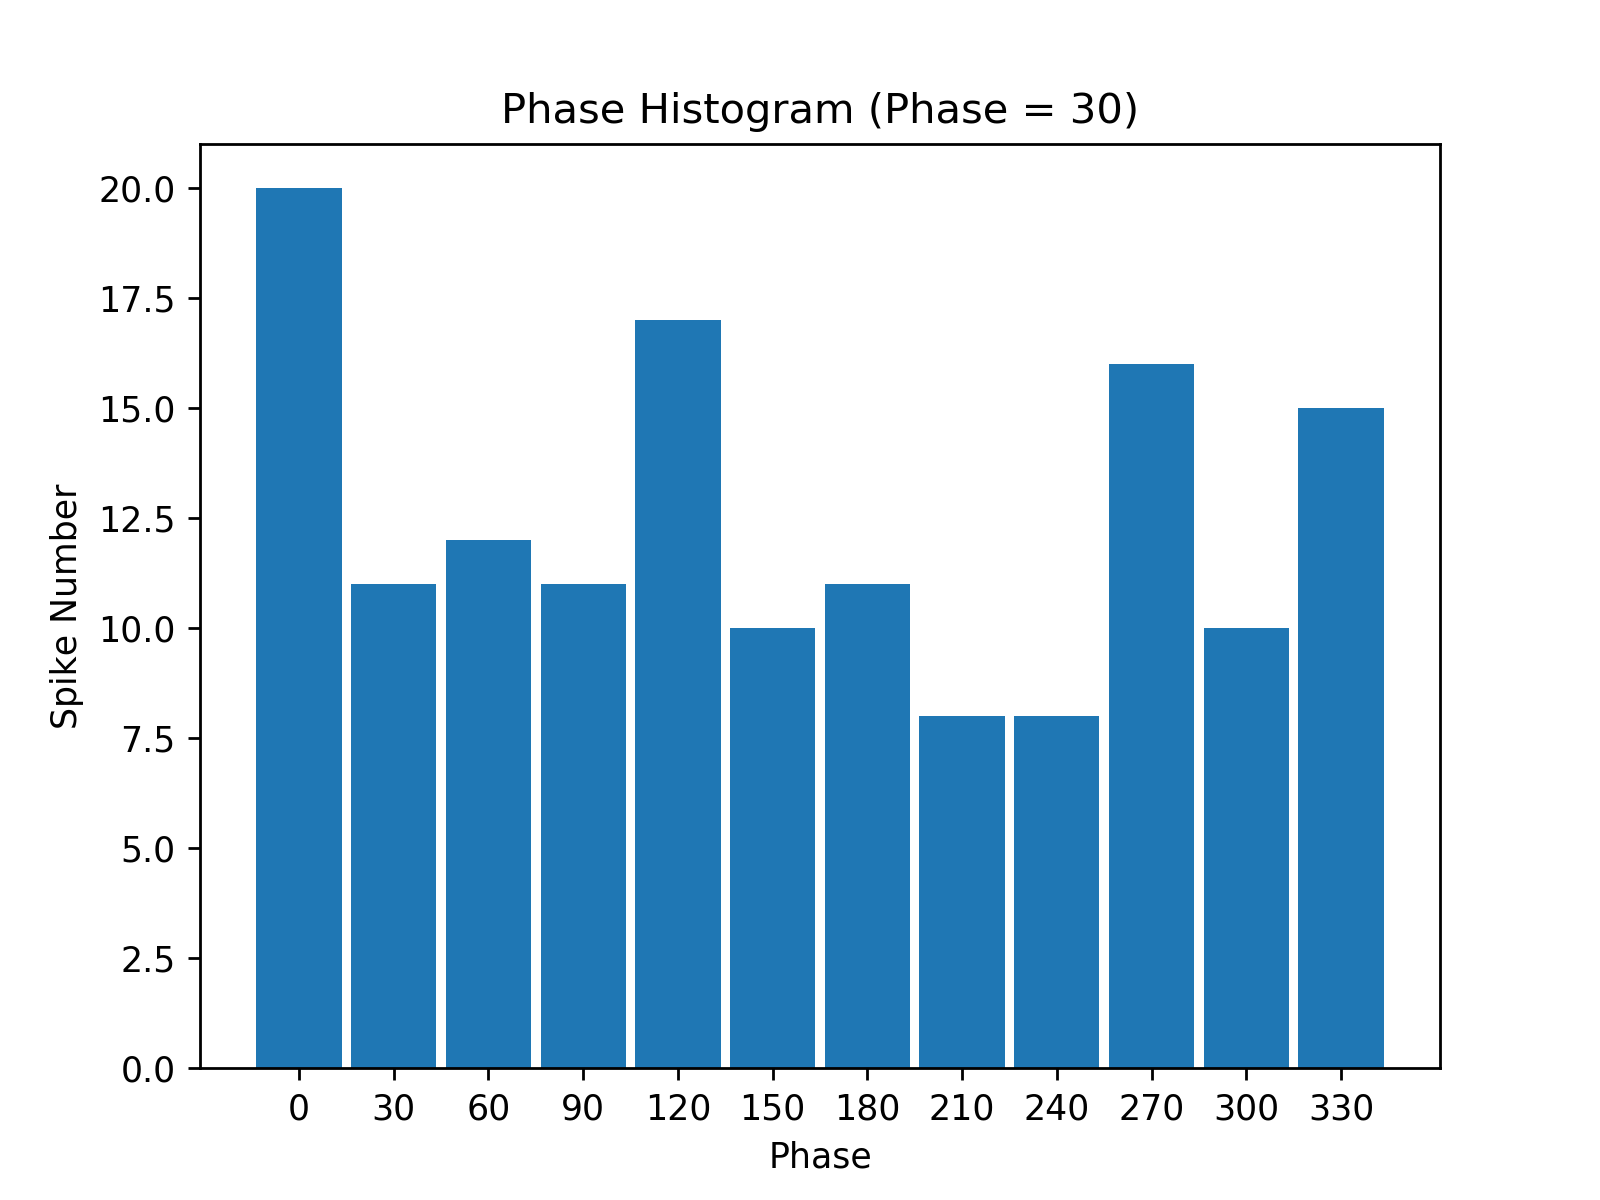

In [26]:
%matplotlib notebook
plot_barchart(unit_hist_arrays['46'], phase)

<IPython.core.display.Javascript object>


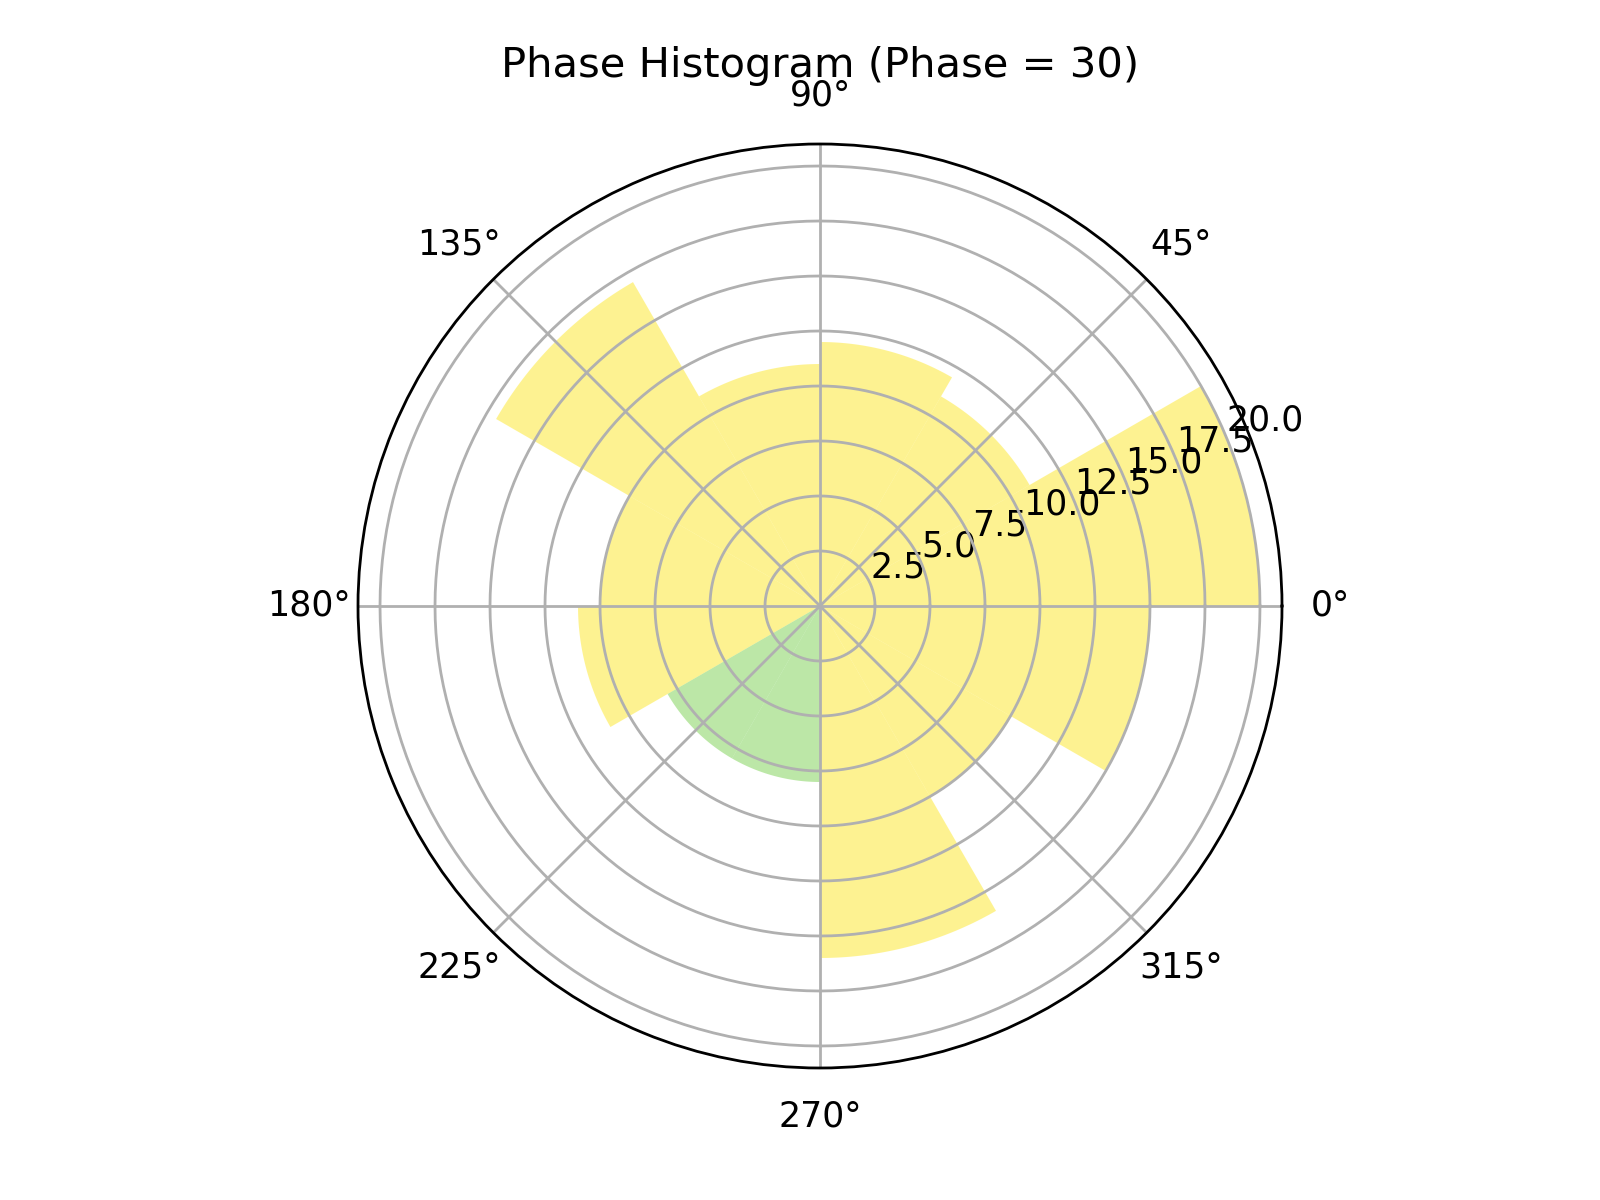

In [27]:
%matplotlib notebook
plot_polarbarchart(unit_hist_arrays['46'], phase)

## 14. Plotting spindle envelope's phase histogram

Here's an example of a spindle envelope phase histogram, with unit index 46 and spindle index 14.

<IPython.core.display.Javascript object>


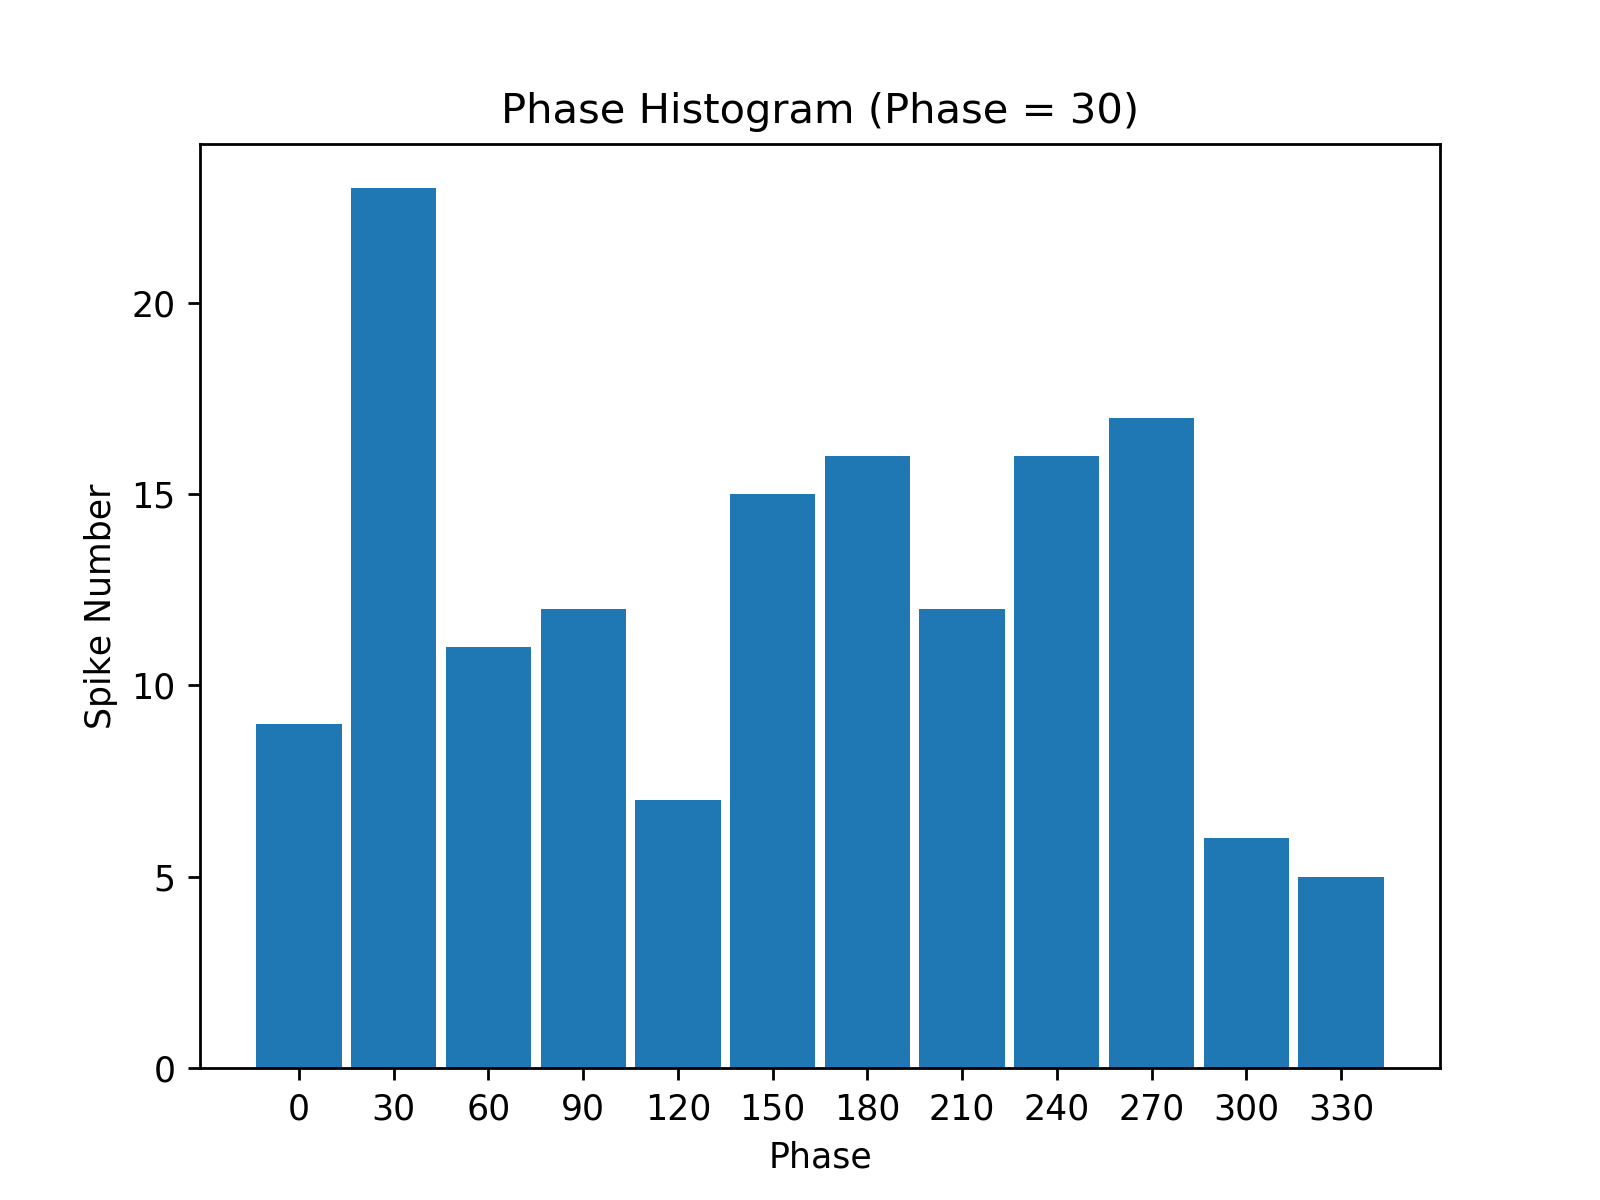

In [28]:
%matplotlib notebook
plot_barchart(unit_hist_envelope_arrays['46'], phase)

<IPython.core.display.Javascript object>


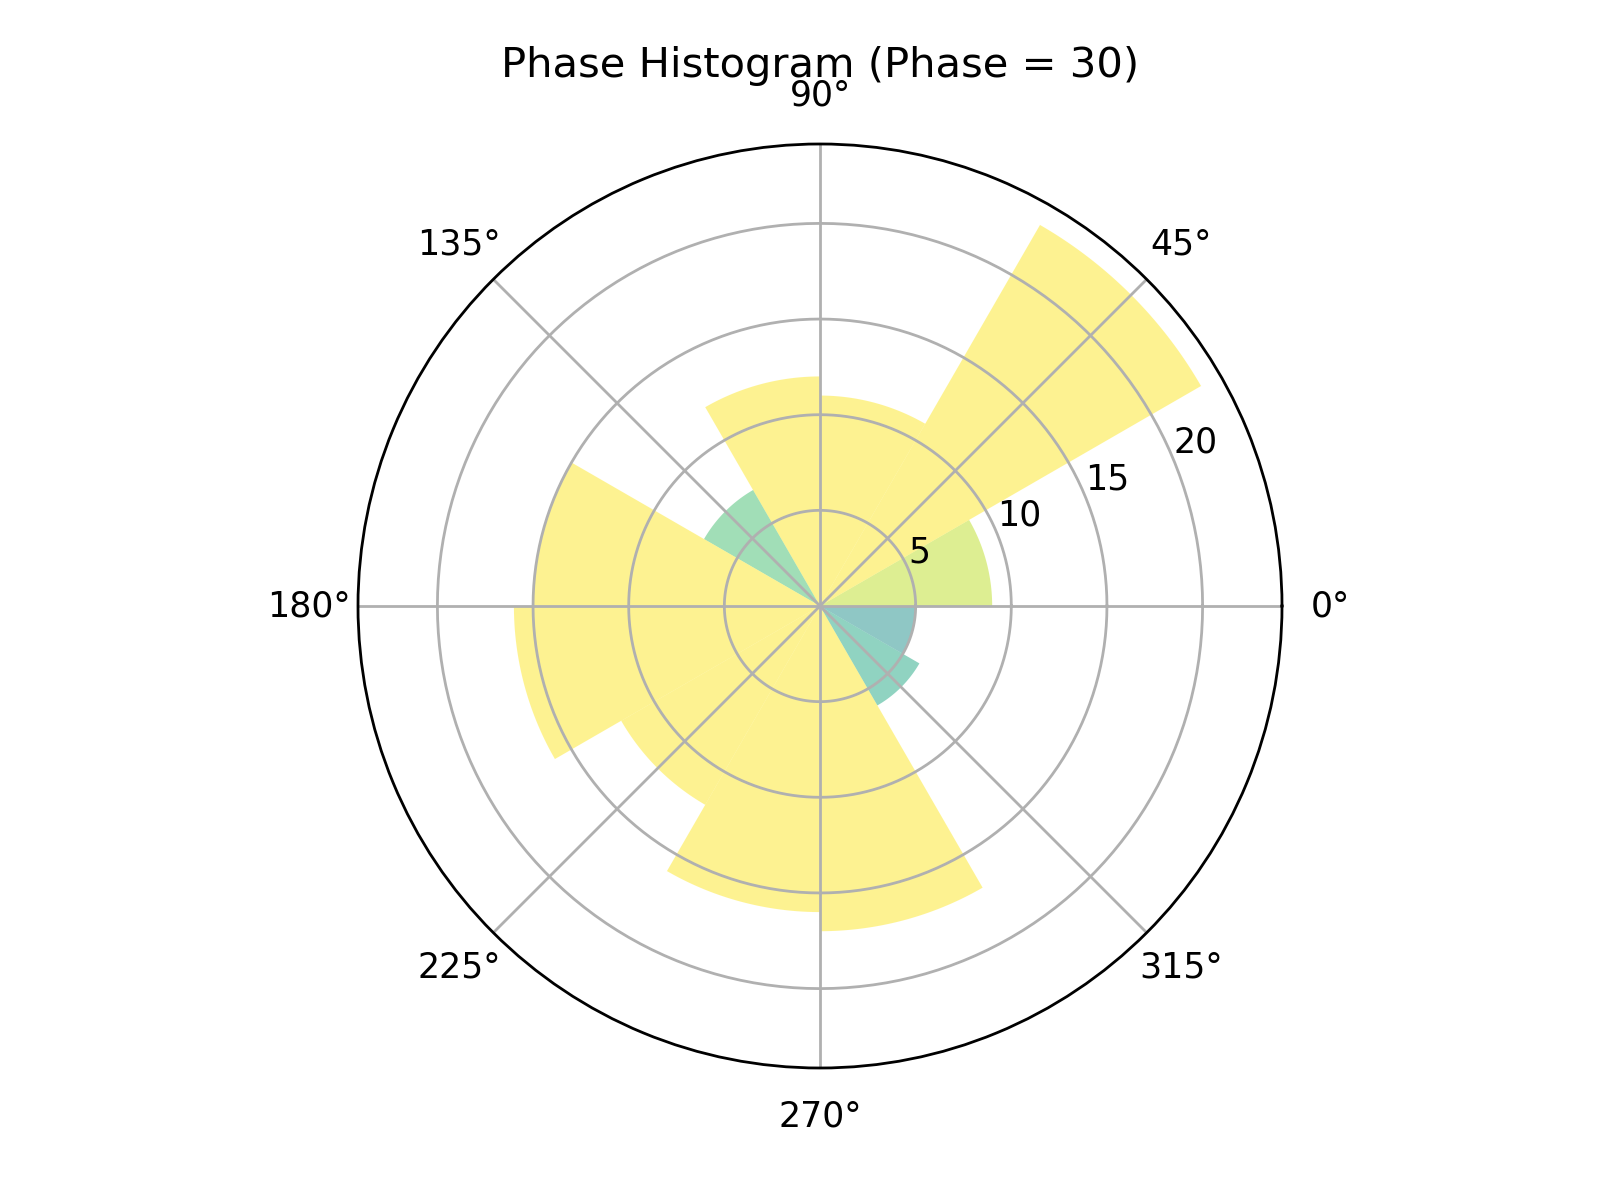

In [29]:
%matplotlib notebook
plot_polarbarchart(unit_hist_envelope_arrays['46'], phase)

## 15. Conclusion
After all, looking at these histogram plots we can understand if there's a modulation between spiking pattern and sleep spindles. 

This notebook is created by Mert Unsal in ETH Zurich Neuroinformatics Lab under supervision of PhD. Tansel Baran Yasar. You can reach me out at mailmertunsal@gmail.com for further questions or discussion.